In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [7]:
# model testing

model = load_model(f'3d_cnn1.h5', compile=False)
pickle_in_x = open("training_data_subsampled_X.pickle", "rb")
pickle_in_y = open("training_data_subsampled_y.pickle", "rb")
X = pickle.load(pickle_in_x)
y = pickle.load(pickle_in_y)


In [9]:
model

1/1 [==============================] - 0s 159ms/step
(180, 240)


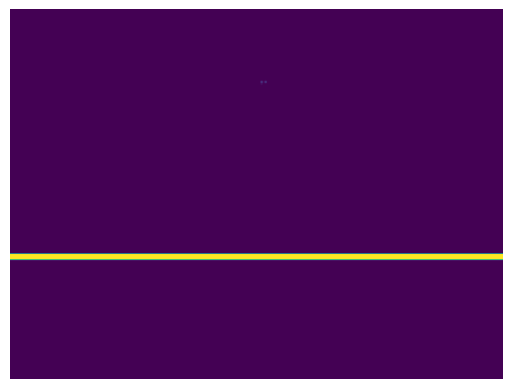

In [12]:
y = model.predict(X[1190].reshape(-1, 895, 16, 16, 1)) * 255
img = y.reshape(180, 240)
fig, ax = plt.subplots()
ax.imshow(img)
plt.axis('off')
print(img.shape)